# HR Analytics - Evaluation

Objective: Create a logistic Reg Model to predict the attrition of employees by using the features available from the datasets given

Created By: Stephen Cole

Creation Date: 18/08/2022

##### Last Updated

In [1]:
from datetime import datetime, timedelta

print(f"Last Updated: {datetime.now().strftime('%d/%m/%Y %H:%M:%S')}")

Last Updated: 24/08/2022 14:15:35


### Import Packages

In [2]:
# Importing all packages in one cell helps to keep the notebook clean and readable as having multiple imports scattered makes
# it hard to keep track of all the packages being used

import pandas as pd
import numpy as np
import os 
import pickle 
import random
import time
import shap
import yaml

from datetime import timedelta

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, precision_score, confusion_matrix, f1_score, classification_report, mean_squared_error, roc_curve, auc, accuracy_score
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.isotonic import IsotonicRegression

import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
%matplotlib inline

# Import DataScience Modelling Functions from file created (ensure the file is in same dir as this notebook)
from functions.DS_Model_Functions import *

In [3]:
pd.set_option("display.max_columns", None, "display.max_rows", 500)

## Define Custom Functions

In [4]:
def calculate_performance(X_test, y_test, model, model_type, thr=0.5, average='weighted'):
    """
    Calculates model performance
    """
    performance = {}
    if "xgboost" in str(model.__class__):
        dtest = xgb.DMatrix(X_test, label=y_test)
        y_pred_prob = model.predict(dtest)
    else:
        y_pred_prob = model.predict(X_test)
    if model_type=='binaryclass':
        performance['acc_score'] = accuracy_score(y_test, y_pred_prob > thr)
        performance['prec_score'] = precision_score(y_test, y_pred_prob > thr)
        performance['rec_score'] = recall_score(y_test, y_pred_prob > thr)
        performance['roc_auc'] = roc_auc_score(y_test, y_pred_prob)
        performance['F1_score'] = f1_score(y_test, y_pred_prob > thr)
        print(classification_report(y_test, y_pred_prob>thr,digits=4))
        
    if model_type=='multiclass':
        y_pred=y_pred_prob.argmax(axis=1)
        performance['acc_score'] = accuracy_score(y_test, y_pred)#,average =average)
        performance['prec_score'] = precision_score(y_test, y_pred,average =average)
        performance['rec_score'] = recall_score(y_test, y_pred,average =average)
        performance['roc_auc'] = roc_auc_score(y_test, y_pred_prob,average =average,multi_class='ovr')

        performance['F1_score'] = f1_score(y_test, y_pred ,average =average)
        print(classification_report(y_test, y_pred,digits=4))
        
    if model_type=='regression':
        y_pred = model.predict(dtest)
        performance['rmse'] = mean_squared_error(y_test, y_pred, squared=False)

    return performance

### Load Objects

In [5]:
with open (os.path.join(os.getcwd(),'config/attrition_config.yaml'),'r') as stream:
    attrition_propensity_config = yaml.safe_load(stream)

In [6]:
path_to_data = attrition_propensity_config['general_config']['path_to_data']

In [7]:
start_time = time.time()
print('start_time', time.asctime( time.localtime(time.time()) ))

X = load_obj(name='Modelling_dset', file_path=path_to_data)
y = load_obj(name='Target', file_path=path_to_data)
features = load_obj(name='features', file_path=path_to_data)
xgb_model = load_obj(name='HR_Attrition_XGB_Model_202208', file_path=path_to_data)
light_model = load_obj(name='HR_Attrition_Light_Model_202208', file_path=path_to_data)

end_time = time.time()
total_time = end_time - start_time
print('total_time to read data', str(timedelta(seconds=total_time)))

start_time Wed Aug 24 14:15:52 2022
total_time to read data 0:00:00.064032


In [8]:
X = X[features]

In [9]:
X.shape

(4410, 27)

In [10]:
print('Features:', features, 'Number of features:', len(features), sep='\n')

Features:
['maritalstatus_Single', 'totalworkingyears', 'businesstravel_Travel_Frequently', 'environmentsatisfaction_Low', 'educationfield_Human Resources', 'yearswithcurrmanager', 'jobsatisfaction_Very High', 'environmentsatisfaction_Very High', 'yearssincelastpromotion', 'educationfield_Life Sciences', 'numcompaniesworked', 'gender_Female', 'jobsatisfaction_Low', 'worklifebalance_Good', 'jobrole_Research Director', 'department_Human Resources', 'education_Below College', 'worklifebalance_Bad', 'environmentsatisfaction_High', 'jobrole_Sales Representative', 'maritalstatus_Divorced', 'worklifebalance_Better', 'distancefromhome', 'trainingtimeslastyear', 'jobsatisfaction_High', 'education_College', 'education_Bachelor']
Number of features:
27


## Predictions

In [11]:
# Split dataset into train and test datasets for evaluation
# Set the random_state for the same split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [12]:
# Use XGBoost DMatrix for memory efficiency and model training speed

dmat_test = xgb.DMatrix(X_test, label=y_test)

In [13]:
# Make Predictions using the model created

xgb_predictions = xgb_model.predict(dmat_test)
lgb_predictions = light_model.predict(X_test)

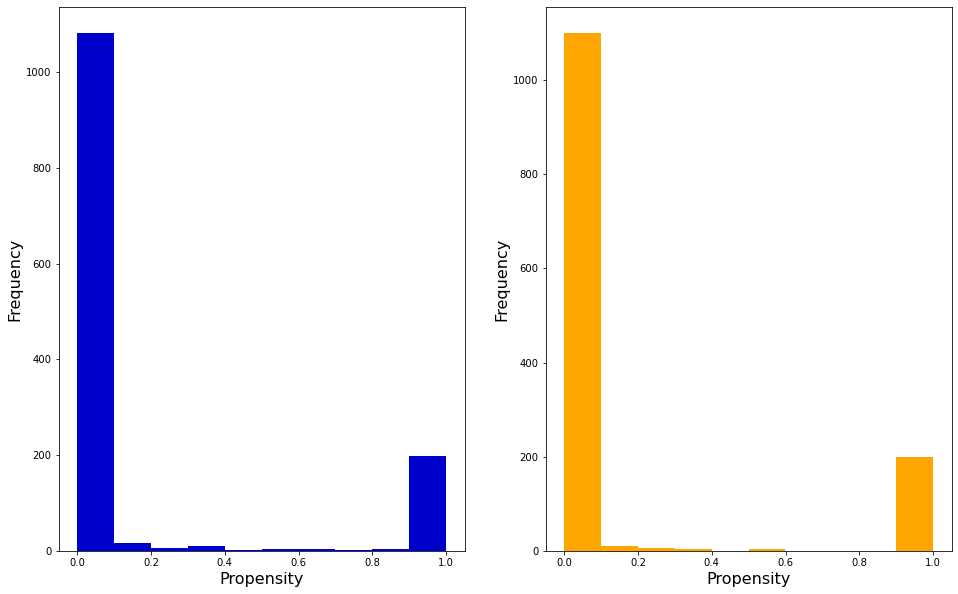

In [14]:
fig, ax = plt.subplots(1,2, figsize=(16,10))

ax[0].hist(xgb_predictions, color='mediumblue')
ax[1].hist(lgb_predictions, color='orange')

# Set common labels
for i in [0,1]:
    ax[i].set_xlabel('Propensity', fontsize=16)
    ax[i].set_ylabel('Frequency', fontsize=16)

### Confidence Matrices (threshold = 0.5)

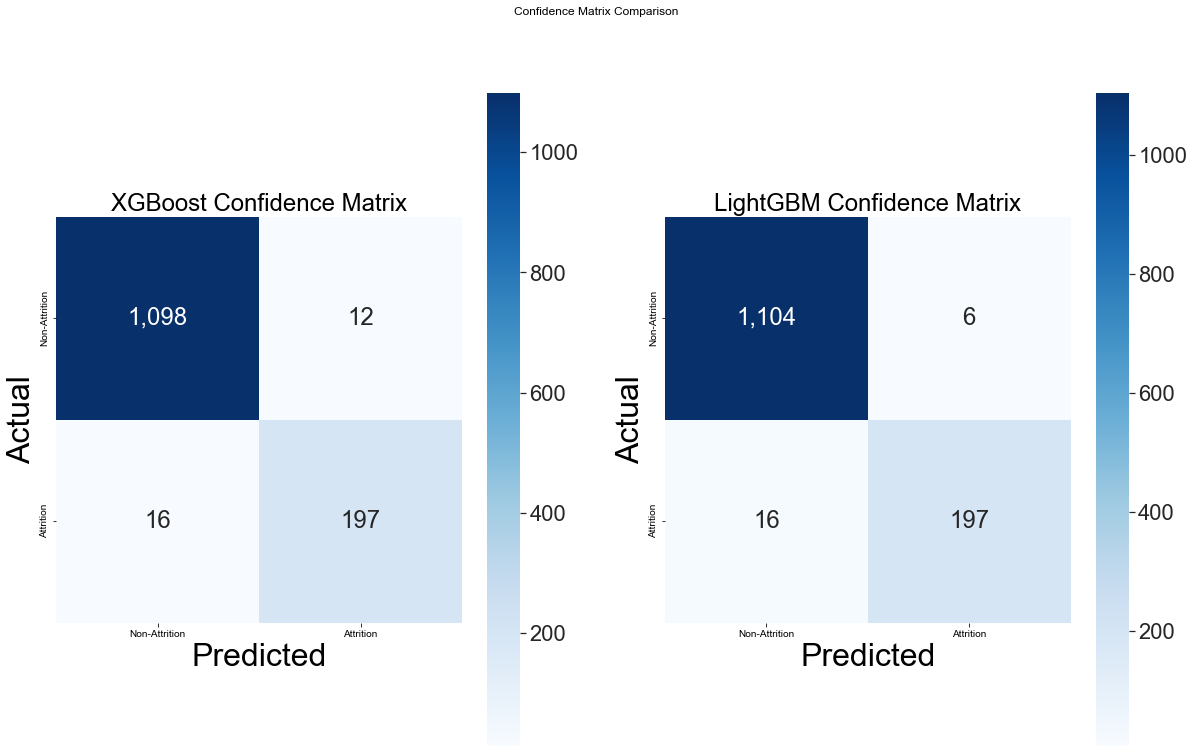

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(20,12))
fig.suptitle('Confidence Matrix Comparison')

sns.set_context('talk')
sns.set(font_scale=2)

sns.heatmap(confusion_matrix(y_test, xgb_predictions>=0.5),
            annot_kws = {"size": 24},
            fmt = ',d',
            cmap = 'Blues',
            square = True,
            xticklabels = ['Non-Attrition', 'Attrition'],
            yticklabels = ['Non-Attrition', 'Attrition'],
            annot=True,
            ax=ax[0]).set_title("XGBoost Confidence Matrix");

sns.heatmap(confusion_matrix(y_test, lgb_predictions>=0.5),
            annot_kws = {"size": 24},
            fmt = ',d',
            cmap = 'Blues',
            square = True,
            xticklabels = ['Non-Attrition', 'Attrition'],
            yticklabels = ['Non-Attrition', 'Attrition'],
            annot=True,
            ax=ax[1]).set_title("LightGBM Confidence Matrix");

for i in [0,1]:
    ax[i].set_xlabel('Predicted', fontsize=32)
    ax[i].set_ylabel('Actual', fontsize=32)

In [16]:
xgb_performance = calculate_performance(X_test=X_test, y_test=y_test, model=xgb_model, model_type='binaryclass')

              precision    recall  f1-score   support

           0     0.9856    0.9892    0.9874      1110
           1     0.9426    0.9249    0.9336       213

    accuracy                         0.9788      1323
   macro avg     0.9641    0.9570    0.9605      1323
weighted avg     0.9787    0.9788    0.9788      1323



In [17]:
lgb_performance = calculate_performance(X_test=X_test, y_test=y_test, model=light_model, model_type='binaryclass')

              precision    recall  f1-score   support

           0     0.9857    0.9946    0.9901      1110
           1     0.9704    0.9249    0.9471       213

    accuracy                         0.9834      1323
   macro avg     0.9781    0.9597    0.9686      1323
weighted avg     0.9833    0.9834    0.9832      1323



In [18]:
print(xgb_performance, lgb_performance, sep='\n')

{'acc_score': 0.9788359788359788, 'prec_score': 0.9425837320574163, 'rec_score': 0.9248826291079812, 'roc_auc': 0.9722835511567905, 'F1_score': 0.933649289099526}
{'acc_score': 0.983371126228269, 'prec_score': 0.9704433497536946, 'rec_score': 0.9248826291079812, 'roc_auc': 0.9679989849003934, 'F1_score': 0.9471153846153846}


Have very promising results but won't be certain until we look at the Gain and Lift Charts. Will also create an ROC curve in case future iterations of the model will be created and can be used to compare the performance of any different iterations.

In [19]:
dtrain = xgb.DMatrix(X_train, label=y_train)
xgb_train_preds = xgb_model.predict(dtrain)
lgb_train_preds = light_model.predict(X_train)

In [20]:
print('XGB Training set ROC AUC score: {:.4f}'.format(roc_auc_score(y_train, xgb_train_preds >= 0.5)))
print('XGB Test set ROC AUC score: {:.4f}'.format(xgb_performance['roc_auc']))

print()

print('LGB Training set ROC AUC score: {:.4f}'.format(roc_auc_score(y_train, lgb_train_preds >= 0.5)))
print('LGB Test set ROC AUC score: {:.4f}'.format(lgb_performance['roc_auc']))

XGB Training set ROC AUC score: 1.0000
XGB Test set ROC AUC score: 0.9723

LGB Training set ROC AUC score: 1.0000
LGB Test set ROC AUC score: 0.9680


#### Find optimal threshold

This is only useful if you are directly interested in the classes outcome. Otherwise, we would only need to look at the top deciles of the model's predictions to determine if enough of the employee base can be predicted for attrition.

See : https://towardsdatascience.com/optimal-threshold-for-imbalanced-classification-5884e870c293

In [21]:
xgb_fpr, xgb_tpr, xgb_thresholds = roc_curve(y_test, xgb_predictions)
lgb_fpr, lgb_tpr, lgb_thresholds = roc_curve(y_test, lgb_predictions)

# The geometric mean or known as G-mean is the geometric mean of sensitivity and specificity. 
# So, it will be one of the unbiased evaluation metrics for imbalanced classification.

xgb_gmean = np.sqrt(xgb_tpr * (1 - xgb_fpr)) 
lgb_gmean = np.sqrt(lgb_tpr * (1 - lgb_fpr)) 

In [22]:
xgb_index = np.argmax(xgb_gmean)
xgb_thresholdOpt = round(xgb_thresholds[xgb_index], ndigits = 4)
xgb_gmeanOpt = round(xgb_gmean[xgb_index], ndigits = 4)
xgb_fprOpt = round(xgb_fpr[xgb_index], ndigits = 4)
xgb_tprOpt = round(xgb_tpr[xgb_index], ndigits = 4)

print('XGB Best Threshold: {} with G-Mean: {}'.format(xgb_thresholdOpt, xgb_gmeanOpt))
print('XGB FPR: {}, XGB TPR: {}'.format(xgb_fprOpt, xgb_tprOpt))

XGB Best Threshold: 0.7971000075340271 with G-Mean: 0.9591
XGB FPR: 0.0054, XGB TPR: 0.9249


In [23]:
lgb_index = np.argmax(lgb_gmean)
lgb_thresholdOpt = round(lgb_thresholds[lgb_index], ndigits = 4)
lgb_gmeanOpt = round(lgb_gmean[lgb_index], ndigits = 4)
lgb_fprOpt = round(lgb_fpr[lgb_index], ndigits = 4)
lgb_tprOpt = round(lgb_tpr[lgb_index], ndigits = 4)

print('XGB Best Threshold: {} with G-Mean: {}'.format(lgb_thresholdOpt, lgb_gmeanOpt))
print('XGB FPR: {}, XGB TPR: {}'.format(lgb_fprOpt, lgb_tprOpt))

XGB Best Threshold: 0.5752 with G-Mean: 0.9604
XGB FPR: 0.0027, XGB TPR: 0.9249


### Confidence Matrix with new thresholds

In [24]:
xgb_performance = calculate_performance(X_test=X_test, y_test=y_test, model=xgb_model, 
                                        thr=xgb_thresholdOpt, model_type='binaryclass')

              precision    recall  f1-score   support

           0     0.9857    0.9946    0.9901      1110
           1     0.9704    0.9249    0.9471       213

    accuracy                         0.9834      1323
   macro avg     0.9781    0.9597    0.9686      1323
weighted avg     0.9833    0.9834    0.9832      1323



In [25]:
lgb_performance = calculate_performance(X_test=X_test, y_test=y_test, model=light_model, 
                                        thr=lgb_thresholdOpt, model_type='binaryclass')

              precision    recall  f1-score   support

           0     0.9858    0.9973    0.9915      1110
           1     0.9850    0.9249    0.9540       213

    accuracy                         0.9856      1323
   macro avg     0.9854    0.9611    0.9727      1323
weighted avg     0.9856    0.9856    0.9855      1323



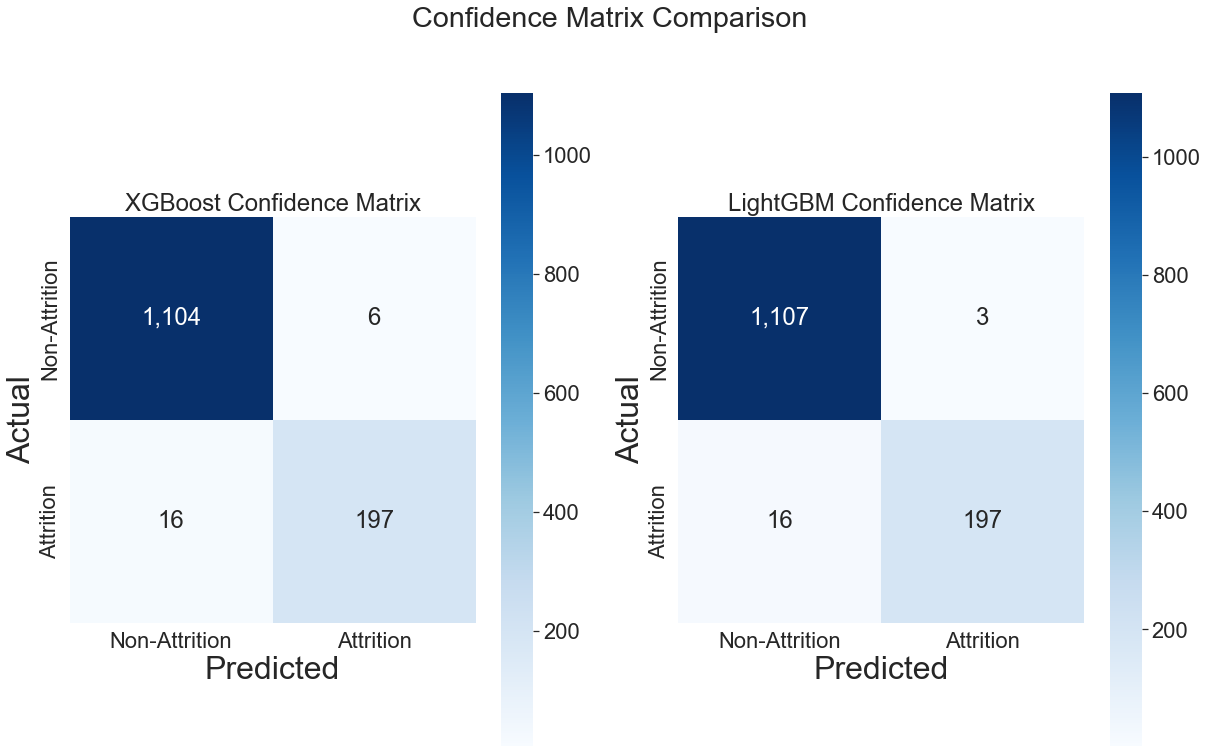

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(20,12))
fig.suptitle('Confidence Matrix Comparison')

sns.set_context('talk')
sns.set(font_scale=2)

sns.heatmap(confusion_matrix(y_test, xgb_predictions>=xgb_thresholdOpt),
            annot_kws = {"size": 24},
            fmt = ',d',
            cmap = 'Blues',
            square = True,
            xticklabels = ['Non-Attrition', 'Attrition'],
            yticklabels = ['Non-Attrition', 'Attrition'],
            annot=True,
            ax=ax[0]).set_title("XGBoost Confidence Matrix");

sns.heatmap(confusion_matrix(y_test, lgb_predictions>=lgb_thresholdOpt),
            annot_kws = {"size": 24},
            fmt = ',d',
            cmap = 'Blues',
            square = True,
            xticklabels = ['Non-Attrition', 'Attrition'],
            yticklabels = ['Non-Attrition', 'Attrition'],
            annot=True,
            ax=ax[1]).set_title("LightGBM Confidence Matrix");

for i in [0,1]:
    ax[i].set_xlabel('Predicted', fontsize=32)
    ax[i].set_ylabel('Actual', fontsize=32)

Able to reduce the number of incorrectly attritioned employees which is good because we don't want to target anyone who isn't likely to attrition. These would be on the lower end of the postively predicted classes anyway so looking at the top 2 deciles for predictions would avoid this issue.

## ROC Curve

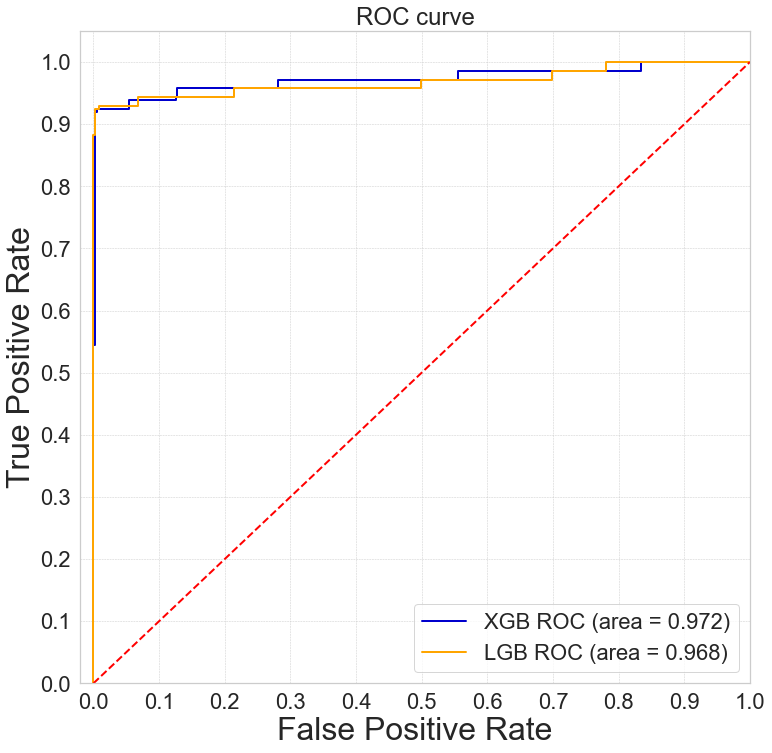

In [27]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 12))
plt.plot(xgb_fpr, xgb_tpr, color='mediumblue', lw=2, label='XGB ROC (area = {0:.3f})'.format(auc(xgb_fpr, xgb_tpr))) # Calculated already when looking at gmean
plt.plot(lgb_fpr, lgb_tpr, color='orange', lw=2, label='LGB ROC (area = {0:.3f})'.format(auc(lgb_fpr, lgb_tpr))) # Calculated already when looking at gmean
plt.plot([0,1], [0,1], color='red', lw=2, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(np.linspace(0,1,11))
plt.yticks(np.linspace(0,1,11))
plt.grid(True, which='major', linestyle='--', linewidth=0.5, zorder=0)
plt.xlabel('False Positive Rate', fontsize=32)
plt.ylabel('True Positive Rate', fontsize=32)
plt.title('ROC curve')
plt.legend(loc="lower right")

plt.show()

The curve isnt smooth as we have a very small dataset to test with. Ideally we would use a large dataset that wasnt used for training. But the performance of the model is extremely good.

#### Lift and Gain

In [28]:
y_df = pd.DataFrame(y_test)

In [29]:
# XGB Gain
xgb_lift = pd.DataFrame([i for i in zip(xgb_predictions,y_df.apply(lambda x: x[0], axis = 1).to_numpy())]).sort_values(0, ascending = False)
xgb_lift['cumpos'] = xgb_lift[1].cumsum()
auc(np.array(range(xgb_lift.shape[0]))/xgb_lift.shape[0],(xgb_lift['cumpos']/max(xgb_lift['cumpos'])).to_numpy())

# LGB Gain
lgb_lift = pd.DataFrame([i for i in zip(lgb_predictions,y_df.apply(lambda x: x[0], axis = 1).to_numpy())]).sort_values(0, ascending = False)
lgb_lift['cumpos'] = lgb_lift[1].cumsum()
auc(np.array(range(lgb_lift.shape[0]))/lgb_lift.shape[0],(lgb_lift['cumpos']/max(lgb_lift['cumpos'])).to_numpy())

0.8926504352393018

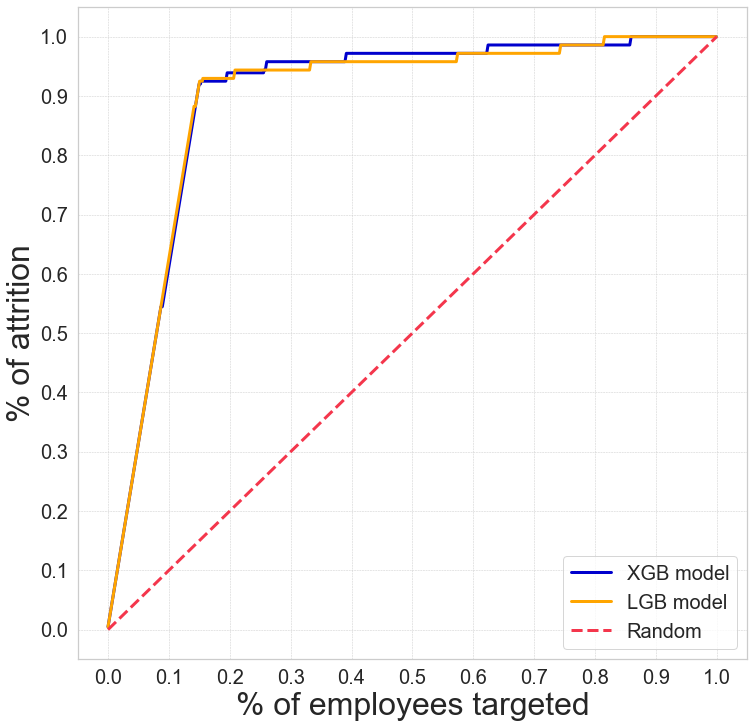

In [30]:
pd.Series((xgb_lift['cumpos']/max(xgb_lift['cumpos'])).to_numpy(), index = np.array(range(xgb_lift.shape[0]))/xgb_lift.shape[0]).plot.line(fontsize = 20, lw = 3, zorder = 3, color = ['mediumblue','#f4364c'], figsize = (12,12))
pd.Series((lgb_lift['cumpos']/max(lgb_lift['cumpos'])).to_numpy(), index = np.array(range(lgb_lift.shape[0]))/lgb_lift.shape[0]).plot.line(fontsize = 20, lw = 3, zorder = 3, color = ['orange','#f4364c'], figsize = (12,12))
pd.Series([0,1], index = [0,1]).plot.line(fontsize = 20, lw = 3, zorder = 3, color = ['#f4364c'], linestyle='--', figsize = (12,12))


plt.ylabel('% of attrition', fontsize = 32)
plt.xlabel('% of employees targeted', fontsize = 32)
plt.xticks(np.linspace(0,1,11))
plt.yticks(np.linspace(0,1,11))
plt.legend(['XGB model','LGB model','Random'],fontsize = 20, loc='lower right')
plt.grid(True, which='major', linestyle='--', linewidth=0.5, zorder = 0)

In [31]:
xgb_lift2 = pd.Series((xgb_lift['cumpos']/max(xgb_lift['cumpos'])).to_numpy(), index = np.array(range(xgb_lift.shape[0]))/xgb_lift.shape[0]).div(np.array(range(xgb_lift.shape[0]))/xgb_lift.shape[0])
lgb_lift2 = pd.Series((lgb_lift['cumpos']/max(lgb_lift['cumpos'])).to_numpy(), index = np.array(range(lgb_lift.shape[0]))/lgb_lift.shape[0]).div(np.array(range(lgb_lift.shape[0]))/lgb_lift.shape[0])

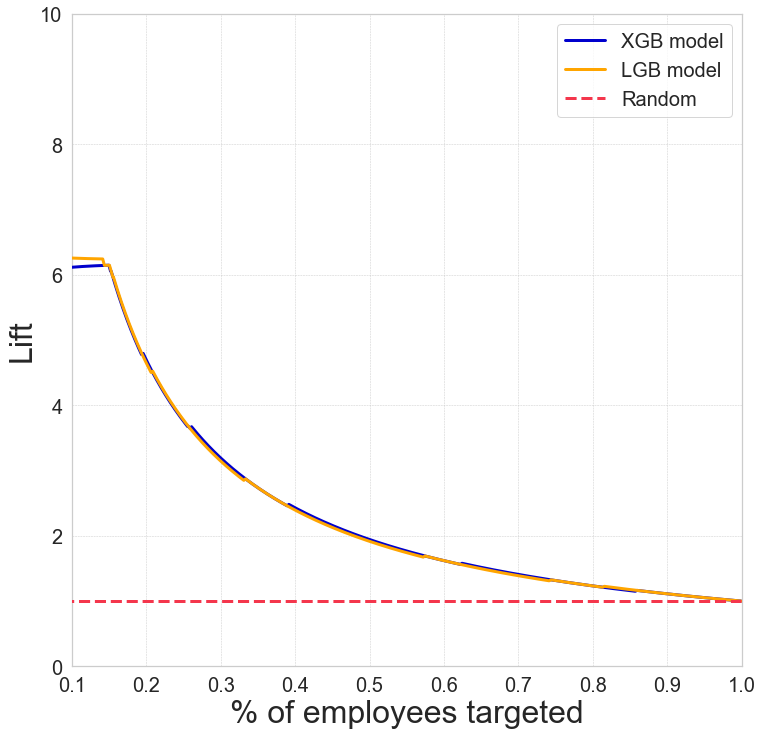

In [32]:
xgb_lift2.iloc[1:].plot.line(fontsize = 20, lw = 3, zorder = 3, color = 'mediumblue', figsize = (12,12))
lgb_lift2.iloc[1:].plot.line(fontsize = 20, lw = 3, zorder = 3, color = 'orange', figsize = (12,12))

pd.Series([1,1], index = [min(xgb_lift2.iloc[1:].index), max(xgb_lift2.iloc[1:].index)]).plot.line(fontsize = 20, lw = 3, zorder = 3, color = ['#f4364c'], linestyle='--', figsize=(12,12))
plt.ylabel('Lift', fontsize = 32)
plt.xticks([i/10 for i in range(0,11,1)])
plt.xlabel('% of employees targeted', fontsize = 32);
plt.legend(['XGB model','LGB model','Random'],fontsize = 20)
plt.xlim([0.1,1])
plt.ylim([0,10])
plt.grid(True, which='major', linestyle='--', linewidth=0.5, zorder = 0)

Overall both models are very similar in terms of performance. The sensitivity and specificity is slightly better than the XGBoost in that we predict less false positives. However, if this isn't important for the stakeholder then its best to look at the ROC, lift, and gain charts. There isn't that much of a difference between our training score and test score, though there are signs of some overfitting - this will be hard to account for due to the lack of data available for training. Ideally we would have millions of rows of data to use for training, more unseen data for calibrating the models, and even more unseen data for validation.

Conclusion:
- We will use the XGBoost as our final model due to higher ROC, better Gain, and better Lift.
- Gain - We can correctly identify over 90% of employees that attrition by looking at the top 2 deciles of our model's probabilities.
- Lift - We can identify just under 5x of employees that attrition in comparison to randomly guessing.
- Both models are good enough to industrialise, depending on the business context.

## Reminder: The stakeholder is interested in the most important features

In [33]:
xgb_scores = xgb_model.get_score(importance_type='weight')
xgb_feature_importances = pd.DataFrame.from_dict(xgb_scores, orient='index', columns=['Score'])
xgb_results = xgb_feature_importances.sort_values(by=['Score'], ascending=False)
xgb_results = xgb_results.reset_index()
xgb_results.columns = xgb_results.columns.str.replace('index','Feature')

In [34]:
xgb_results

,Feature,Score
0,totalworkingyears,412.0
1,distancefromhome,383.0
2,yearswithcurrmanager,254.0
3,numcompaniesworked,232.0
4,yearssincelastpromotion,214.0
5,trainingtimeslastyear,184.0
6,educationfield_Life Sciences,95.0
7,maritalstatus_Single,92.0
8,gender_Female,86.0
9,environmentsatisfaction_High,85.0


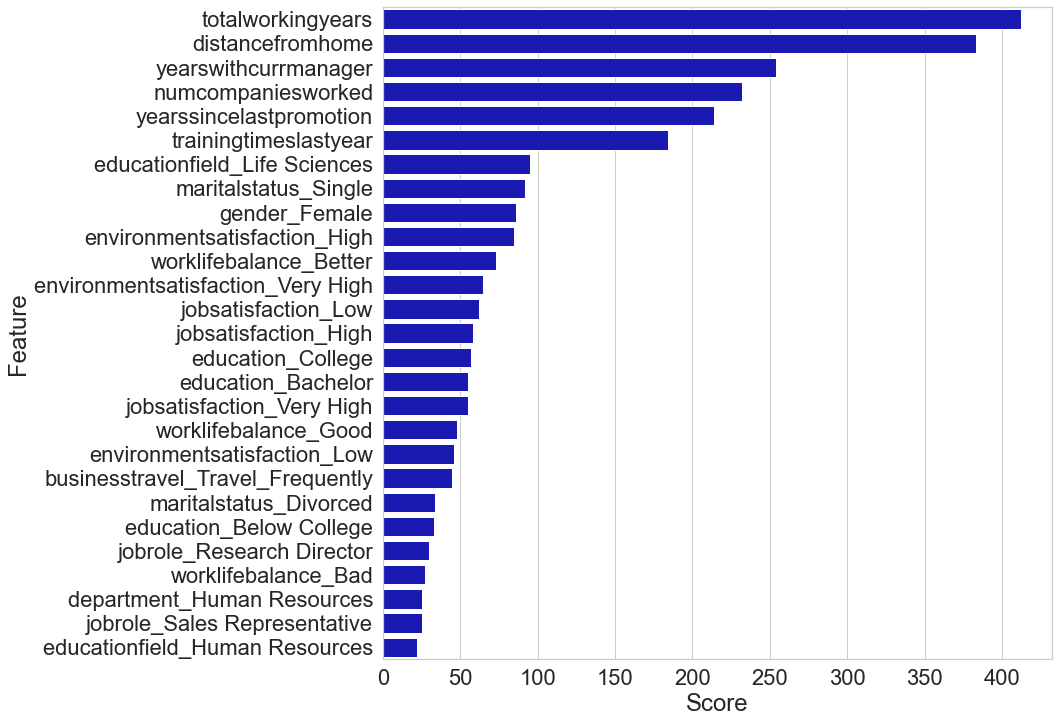

In [35]:
plt.figure(figsize=(12,12))
feature_importance_bar = sns.barplot(x="Score", y='Feature', data=xgb_results,
                                     color="mediumblue")

In [36]:
shap.initjs()

In [37]:
explainer = shap.TreeExplainer(xgb_model)

In [38]:
shap_values = explainer.shap_values(X_test)

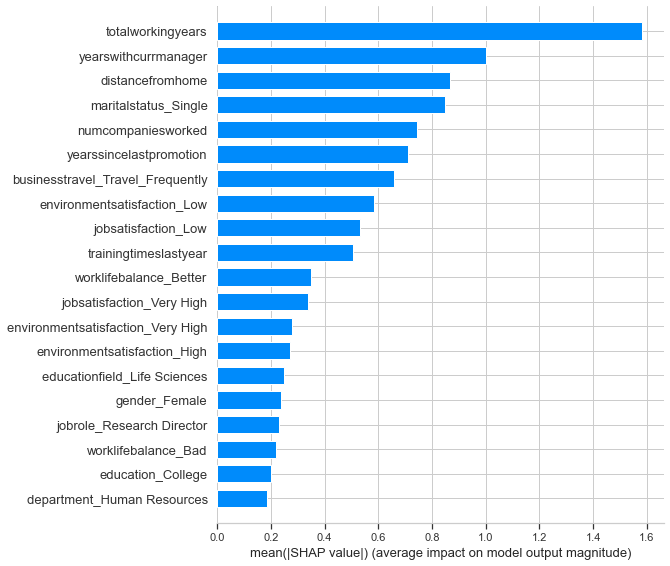

In [39]:
shap.summary_plot(shap_values, X_test, plot_type='bar', show=False)

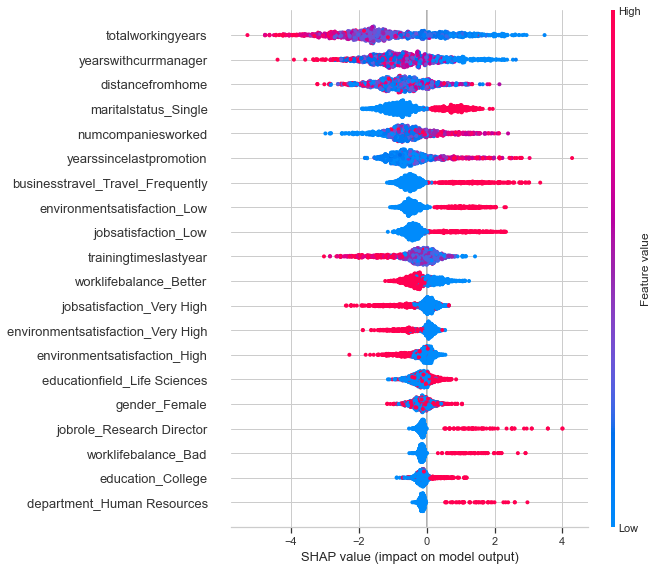

In [40]:
shap.summary_plot(shap_values, X_test)

In [41]:
X_test.iloc[1]

maritalstatus_Single                  0.0
totalworkingyears                     7.0
businesstravel_Travel_Frequently      0.0
environmentsatisfaction_Low           0.0
educationfield_Human Resources        0.0
yearswithcurrmanager                  3.0
jobsatisfaction_Very High             0.0
environmentsatisfaction_Very High     0.0
yearssincelastpromotion               0.0
educationfield_Life Sciences          0.0
numcompaniesworked                    3.0
gender_Female                         1.0
jobsatisfaction_Low                   0.0
worklifebalance_Good                  0.0
jobrole_Research Director             0.0
department_Human Resources            0.0
education_Below College               0.0
worklifebalance_Bad                   0.0
environmentsatisfaction_High          0.0
jobrole_Sales Representative          0.0
maritalstatus_Divorced                0.0
worklifebalance_Better                1.0
distancefromhome                     14.0
trainingtimeslastyear             

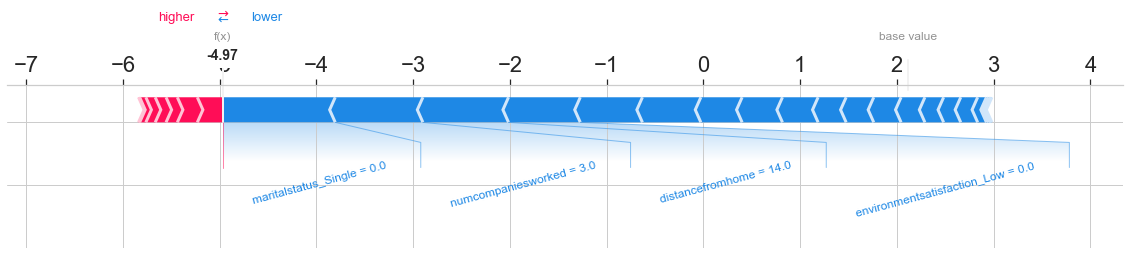

In [42]:
shap_plot = shap.force_plot(explainer.expected_value, 
    shap_values[1], features=X_test.iloc[1], text_rotation=(15),
    matplotlib=True, show=False, plot_cmap=['#77dd77', '#f99191'])

In [43]:
xgb_predictions[1]

0.0068913545

In [44]:
X_test.iloc[50]

maritalstatus_Single                  1.0
totalworkingyears                    10.0
businesstravel_Travel_Frequently      0.0
environmentsatisfaction_Low           0.0
educationfield_Human Resources        0.0
yearswithcurrmanager                  8.0
jobsatisfaction_Very High             0.0
environmentsatisfaction_Very High     0.0
yearssincelastpromotion               1.0
educationfield_Life Sciences          0.0
numcompaniesworked                    1.0
gender_Female                         1.0
jobsatisfaction_Low                   1.0
worklifebalance_Good                  0.0
jobrole_Research Director             0.0
department_Human Resources            0.0
education_Below College               1.0
worklifebalance_Bad                   0.0
environmentsatisfaction_High          1.0
jobrole_Sales Representative          0.0
maritalstatus_Divorced                0.0
worklifebalance_Better                1.0
distancefromhome                     24.0
trainingtimeslastyear             

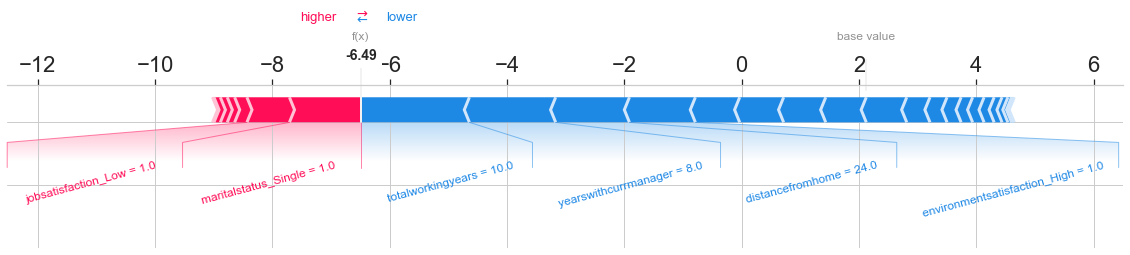

In [45]:
shap_plot = shap.force_plot(explainer.expected_value, 
    shap_values[50], features=X_test.iloc[50], text_rotation=(15),
    matplotlib=True, show=False, plot_cmap=['#77dd77', '#f99191'])

In [46]:
xgb_predictions[50]

0.0015206821

In [47]:
X_test.iloc[0]

maritalstatus_Single                 1.0
totalworkingyears                    3.0
businesstravel_Travel_Frequently     1.0
environmentsatisfaction_Low          0.0
educationfield_Human Resources       0.0
yearswithcurrmanager                 0.0
jobsatisfaction_Very High            1.0
environmentsatisfaction_Very High    0.0
yearssincelastpromotion              0.0
educationfield_Life Sciences         0.0
numcompaniesworked                   7.0
gender_Female                        1.0
jobsatisfaction_Low                  0.0
worklifebalance_Good                 0.0
jobrole_Research Director            0.0
department_Human Resources           0.0
education_Below College              0.0
worklifebalance_Bad                  0.0
environmentsatisfaction_High         1.0
jobrole_Sales Representative         0.0
maritalstatus_Divorced               0.0
worklifebalance_Better               0.0
distancefromhome                     2.0
trainingtimeslastyear                2.0
jobsatisfaction_

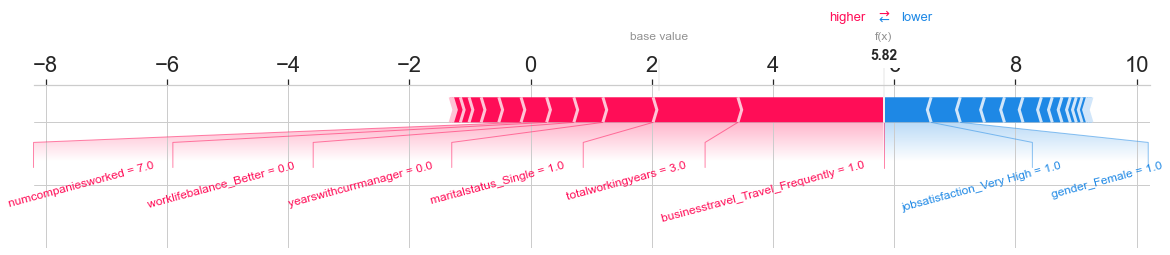

In [48]:
shap_plot = shap.force_plot(explainer.expected_value, 
    shap_values[0], features=X_test.iloc[0], text_rotation=(15),
    matplotlib=True, show=True, plot_cmap=['#77dd77', '#f99191'])

In [49]:
xgb_predictions[0]

0.99705446

## Calibration

Ideally we would also be able to calibrate the dataset. However, we do not have any more un-seen data to do the calibration on. Separating the dataset more would only worsen our model or evaluation so I will leave it out for now. The calibration curve above isn't horrendous either so is fine to leave as is.

# Conclusion

An XGBoost Classifier model is used to calculate the propensities as it showed better performance indicators than the LightGBM for reaching more of the employee base for a very tiny trade off for sensitivity and specificity.

Employees that live closer to the office and have less years with their current manager will contribute the most to their attrition propensity. It is also important to look at the survey metrics they used such as environment and job satisfaction as those who give bad ratings are more likely to leave.

Interestingly, those who also giver ```better``` ratings for work life balance are also potentially going to leave (dependent on other features as well of course) so it would be interesting to question those employees as to the reasoning for why they left, i.e. better opportunity that JWC are not providing or for another reason.

Lastly, those that are single are also likely to leave. This may be due to personal reasons or perhaps a lack of inclusion within the workplace.